In [149]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sympy as sp
import numpy as np
import control as ctl

# EXTRAINDO OS DADOS

In [150]:
df = pd.read_csv('../DataBase.csv')
df = df[['time', 'theta', 'distance']]
df

,time,theta,distance
0,0.00,135,4.15
1,0.00,135,4.15
2,0.01,135,4.15
3,0.01,135,4.15
4,0.01,135,3.91
...,...,...,...
269,4.94,135,20.55
270,4.96,135,20.55
271,4.98,135,20.50
272,5.00,135,20.55


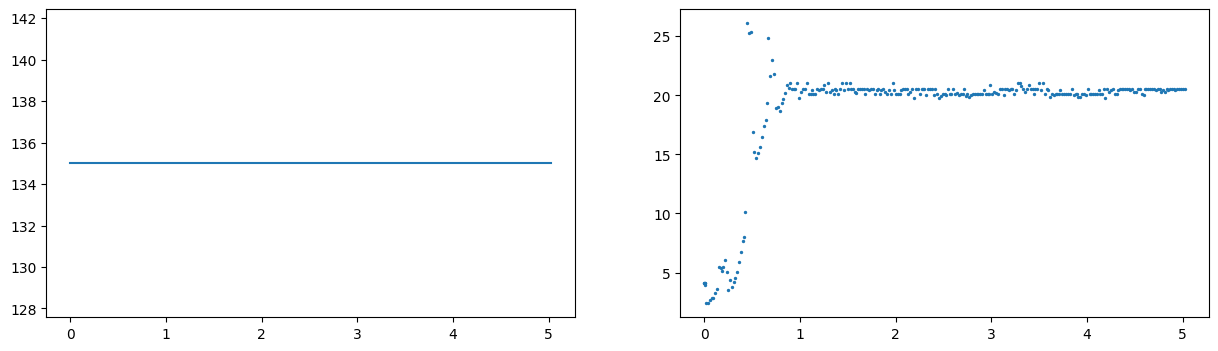

In [151]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(df['time'], df['theta'])

plt.subplot(1, 2, 2)
plt.scatter(df['time'], df['distance'], s=2)

# FILTRANDO OS DADOS

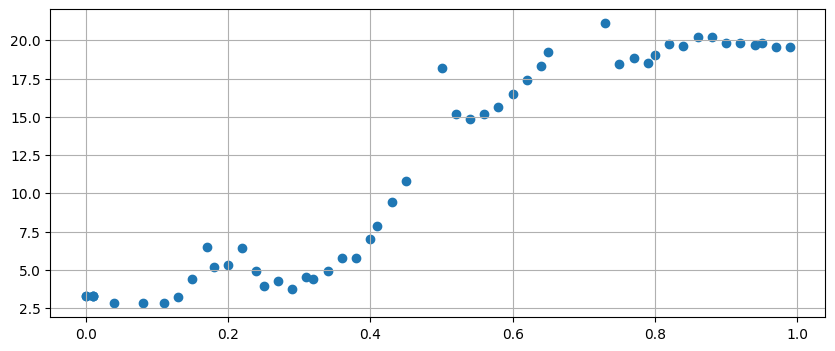

In [132]:
df = df.loc[df['distance'] < 22]
df = df.loc[df['distance'] > 2.5]
df = df.loc[df['time'] < 1]

plt.figure(figsize=(10, 4))
plt.scatter(df['time'], df['distance'])
plt.grid()
plt.show()

In [133]:
positions = np.arange(df['time'].min(), df['time'].max(), 0.1)
positions

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

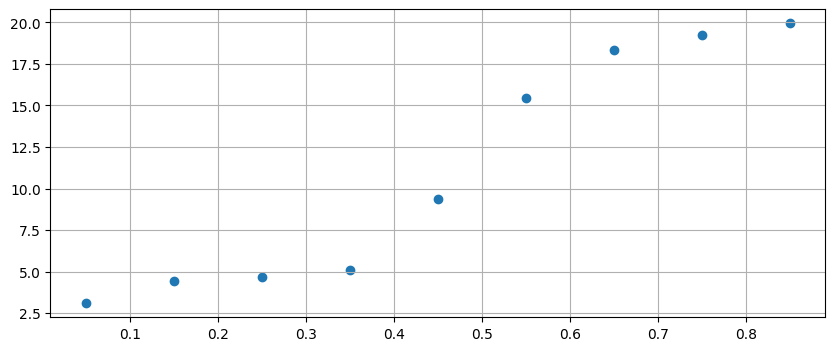

In [134]:
time     = df['time'].to_numpy()
response = df['distance'].to_numpy()

tData = []
yData = []

for i in range(len(positions) - 1):
    position = positions[i]
    next_position = positions[i + 1]

    target = response[(time > position) & (time < next_position)]
    
    if len(target) == 0:
        continue

    t = (next_position + position)/2
    y = target.mean()

    tData.append(t)
    yData.append(y)

plt.figure(figsize=(10, 4))
plt.scatter(tData, yData)
plt.grid()
plt.show()

# ESBOÇANDO O GRÁFICO NO DOMÍNIO DO TEMPO
O gráfico expressa a função de transferência no domínio do tempo $Y(s) = L^{-1}\{y(t)\}$

### ADAPTANDO OS DADOS PARA UMA FUNÇÃO POR CURVE FIT

In [135]:
# Função para uso com curve_fit (NumPy)
def f(t, a, b, c):
    return a*np.exp(b*t) + c

# Função para representação simbólica (SymPy)
def f_sp(t, a, b, c):
    return a*sp.exp(b*t) + c

def getFunction(xDados, yDados):
    coeficientes = curve_fit(f, xDados, yDados, maxfev=1000000000)  # MÁXIMO DE ITERAÇÕES
    return list(coeficientes[0])

def roundSympyFunction(expr, num_digits=10):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

In [136]:
coefs = getFunction(tData, yData)  
f_sp = roundSympyFunction(f_sp(sp.var('t'), *coefs))
f_sp

31.2203115474*exp(0.6042874217*t) - 30.4101373738

### COMPARANDO A FUNÇÃO OBTIDA
Vemos que realmente bate com a função que encontramos apenas pelo gráfico de pontos

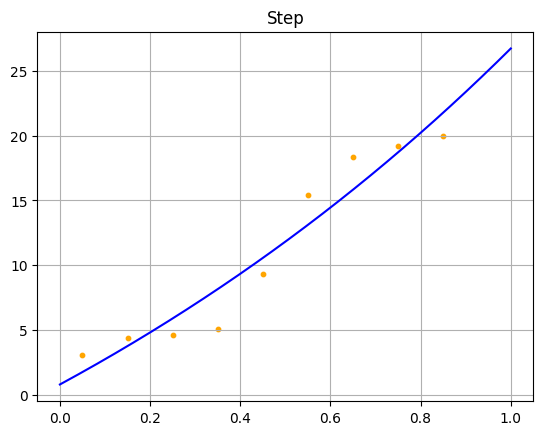

In [137]:
time     = np.linspace(0, 1, 1000)
response = f(time, *coefs)

plt.scatter(tData, yData, color='orange', s=10)
plt.plot(time, response, color='blue')
plt.title('Step')
plt.grid()
plt.show()

In [138]:
def transformadaLaplace(function):   
    t, s = sp.symbols('t s')
    return sp.laplace_transform(function, t, s)[0].expand().simplify()

def transformadaInversaLaplace(function):   
    t, s = sp.symbols('t s')
    return sp.inverse_laplace_transform(function, s, t).expand().simplify()

Y = transformadaLaplace(f_sp)
Y = roundSympyFunction(Y)
Y

(0.8101741736*s + 18.3764635072)/(s*(s - 0.6042874217))

In [148]:
r = 135
R = transformadaLaplace(r)
R

135/s

- A função de transferência é a razão da saída pela entrada, ou seja, $G(s) = \frac{Y(s)}{R(s)}$ 

In [143]:
G = (Y/R).factor()
print(G)

0.136121951905*(0.0440876000589*s + 1.0)/(1.0*s - 0.6042874217)


In [144]:
s = ctl.TransferFunction.s

G = 0.136121951905*(0.0440876000589*s + 1.0)/(1.0*s - 0.6042874217)
G

TransferFunction(array([0.00600129, 0.13612195]), array([ 1.        , -0.60428742]))

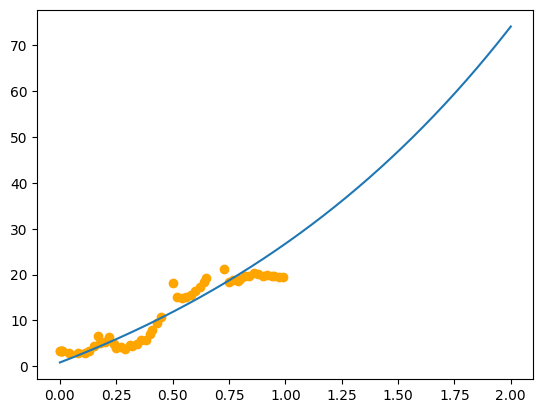

In [147]:
T = np.linspace(0, 2, 1000)
U = r * np.ones(1000)
time, response = ctl.forced_response(G, T=T, U=U)

plt.plot(time, response)
plt.scatter(df['time'], df['distance'], color='orange')